## Import Libraries & Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np
import re

# Load the Likert responses CSV
df_likert = pd.read_csv("../data/likert_responses.csv")
df_likert.head()

,participant,question,original_column,phase,response
0,0,Are you currently enrolled in a university deg...,Are you currently enrolled in a university deg...,yes/no,No
1,1,Are you currently enrolled in a university deg...,Are you currently enrolled in a university deg...,yes/no,Yes
2,2,Are you currently enrolled in a university deg...,Are you currently enrolled in a university deg...,yes/no,Yes
3,3,Are you currently enrolled in a university deg...,Are you currently enrolled in a university deg...,yes/no,Yes
4,4,Are you currently enrolled in a university deg...,Are you currently enrolled in a university deg...,yes/no,Yes


C:\Users\julia\AppData\Local\Temp\ipykernel_6540\556338742.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- I have felt cheerful and in good spirits ---
Independent t-test between before and during: t(59) = 3.60, p < .001
Independent t-test between during and after: t(60) = -2.63, p = 0.011
Independent t-test between before and after: t(59) = 0.90, p = 0.374


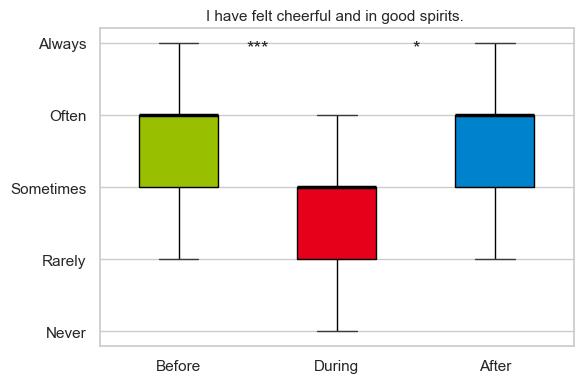


--- In this phase, how often did you feel calm and relaxed? (Question identical to WHO-5 Well-Being Index) ---
Independent t-test between before and during: t(59) = 2.72, p = 0.009
Independent t-test between during and after: t(60) = -1.39, p = 0.171
Independent t-test between before and after: t(59) = 1.40, p = 0.167


C:\Users\julia\AppData\Local\Temp\ipykernel_6540\556338742.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


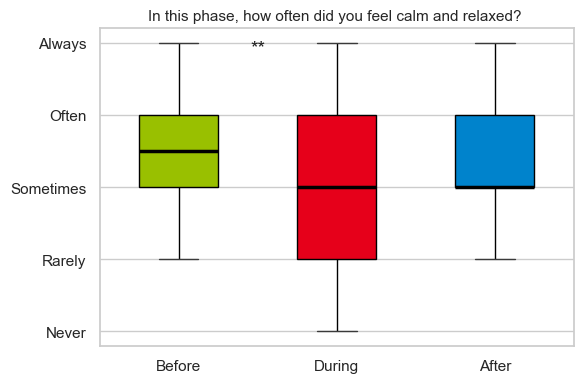

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\556338742.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- I have felt active and vigorous ---
Independent t-test between before and during: t(59) = 4.20, p < .001
Independent t-test between during and after: t(60) = -4.69, p < .001
Independent t-test between before and after: t(59) = -0.35, p = 0.727


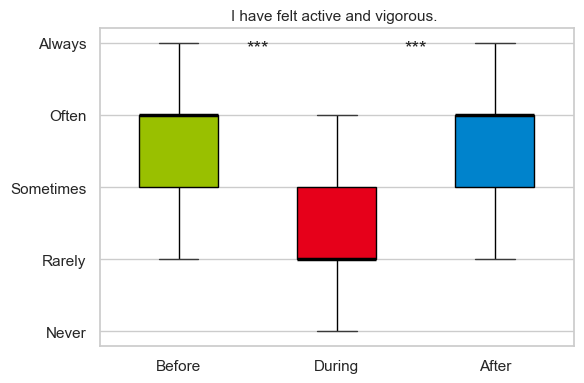

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\556338742.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- I woke up feeling fresh and rested ---
Independent t-test between before and during: t(59) = 3.76, p < .001
Independent t-test between during and after: t(60) = -2.89, p = 0.005
Independent t-test between before and after: t(59) = 0.86, p = 0.393


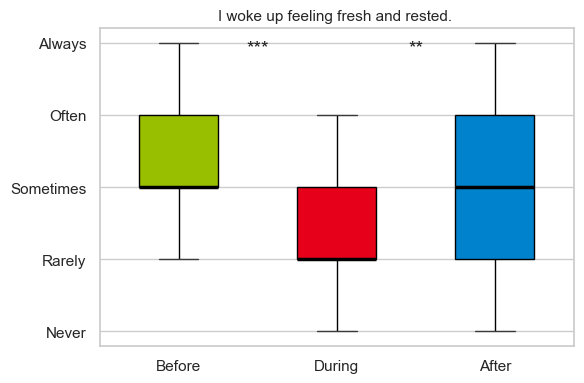

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\556338742.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- My daily life has been filled with things that interest me ---
Independent t-test between before and during: t(59) = 3.01, p = 0.004
Independent t-test between during and after: t(60) = -1.82, p = 0.074
Independent t-test between before and after: t(59) = 1.14, p = 0.260


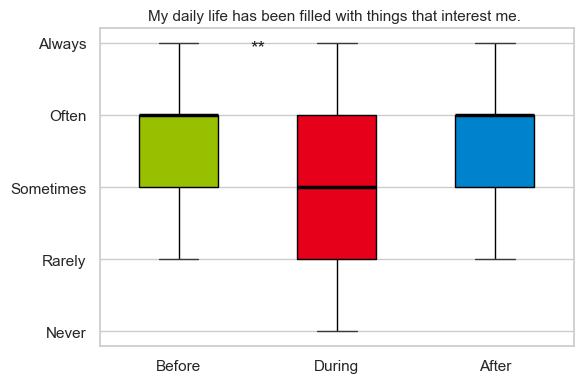

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\556338742.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- I felt significantly anxious or stressed ---
Independent t-test between before and during: t(59) = -3.03, p = 0.004
Independent t-test between during and after: t(60) = 1.95, p = 0.056
Independent t-test between before and after: t(59) = -1.00, p = 0.321


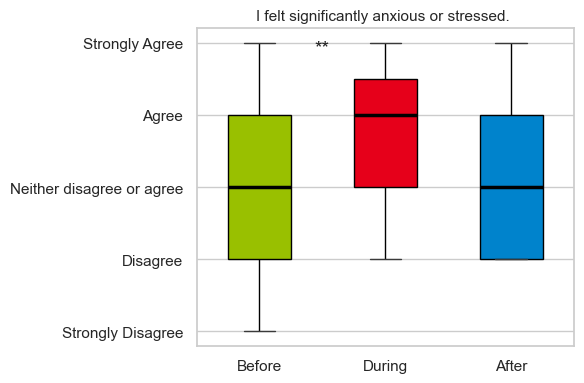

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\556338742.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- I received sufficient mental well-being support from my university ---
Independent t-test between before and during: t(59) = 0.90, p = 0.373
Independent t-test between during and after: t(60) = -0.50, p = 0.619
Independent t-test between before and after: t(59) = 0.43, p = 0.669


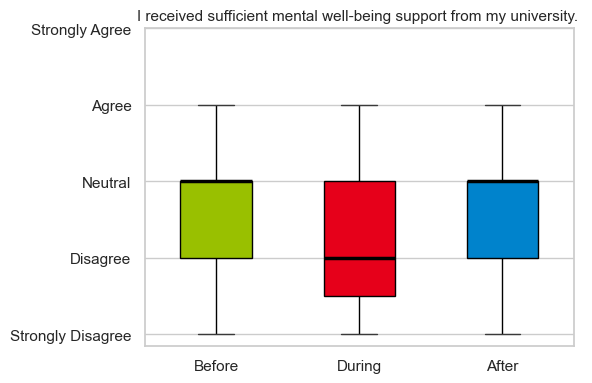

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\556338742.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- How would you rate your academic productivity during this time? (Question adapted from Ralph et al ---
Independent t-test between before and during: t(59) = 3.02, p = 0.004
Independent t-test between during and after: t(60) = -3.56, p < .001
Independent t-test between before and after: t(59) = -0.72, p = 0.472


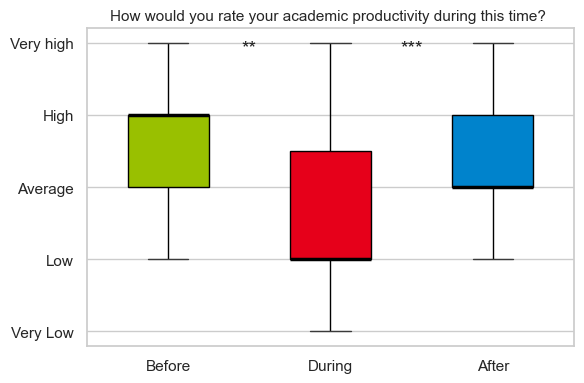

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\556338742.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- How much was your academic workload on average? (Question adapted from Baticulon et al ---
Independent t-test between before and during: t(59) = 0.49, p = 0.623
Independent t-test between during and after: t(60) = -0.50, p = 0.616
Independent t-test between before and after: t(59) = -0.08, p = 0.936


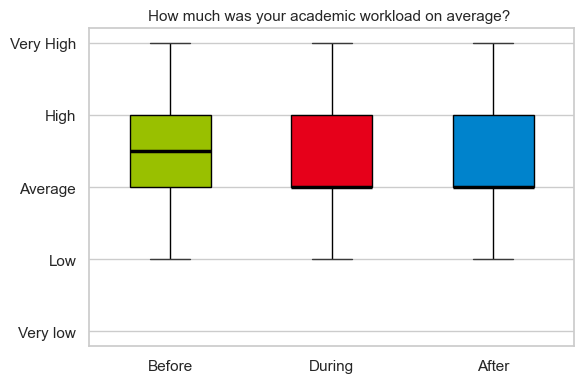

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\556338742.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- Did you feel pressure to appear constantly available or responsive for academic obligations? (Question adapted from Ralph et al ---
Independent t-test between before and during: t(59) = 0.52, p = 0.604
Independent t-test between during and after: t(60) = -1.46, p = 0.150
Independent t-test between before and after: t(59) = -1.14, p = 0.259


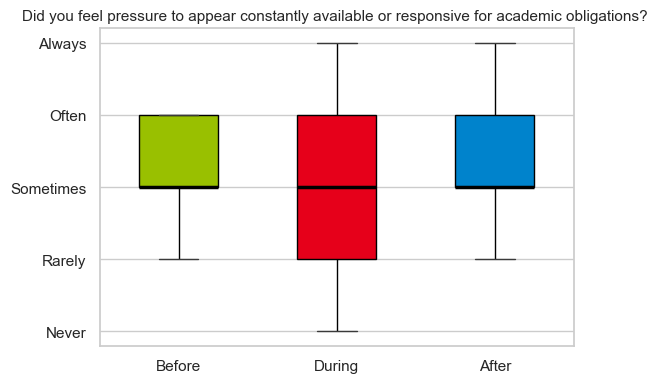

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\556338742.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- Were you able to stay on top of your academic tasks during this time? (Question inspired by Ralph et al ---
Independent t-test between before and after: t(90) = 2.76, p = 0.007


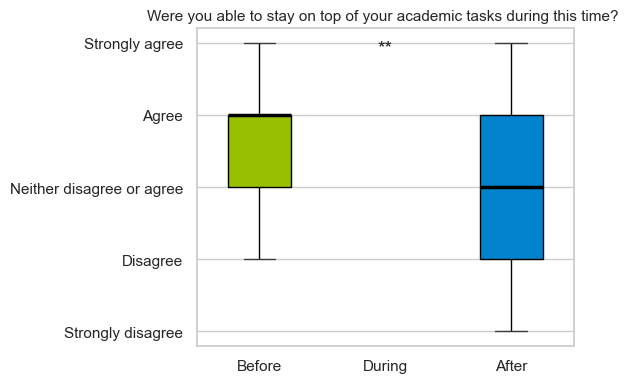

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\556338742.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- How confident did you feel in the quality of your academic work? (Question adapted from Ralph et al ---
Independent t-test between before and during: t(59) = 1.81, p = 0.076
Independent t-test between during and after: t(60) = -1.89, p = 0.063
Independent t-test between before and after: t(59) = -0.08, p = 0.934


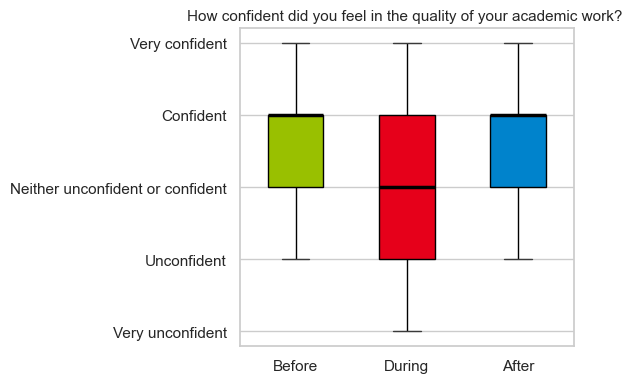

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\556338742.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- Did you feel pressure to appear constantly online or available at work? (Question adapted from Ralph et al ---
Independent t-test between before and during: t(47) = -1.67, p = 0.103
Independent t-test between during and after: t(49) = 1.56, p = 0.126
Independent t-test between before and after: t(50) = 0.03, p = 0.979


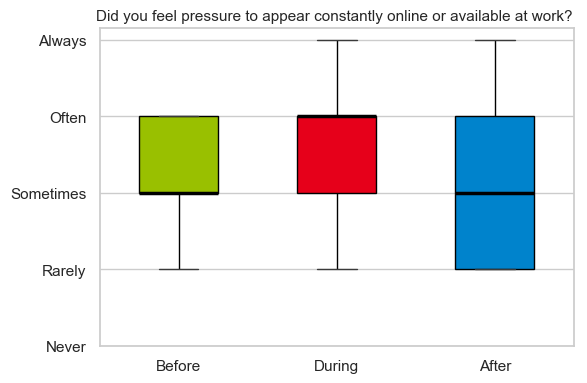


--- How confident were you in the quality of your work-related output? (Question adapted from Ralph et al ---
Independent t-test between before and during: t(48) = 0.13, p = 0.895
Independent t-test between during and after: t(49) = -0.56, p = 0.576
Independent t-test between before and after: t(51) = -0.59, p = 0.561


C:\Users\julia\AppData\Local\Temp\ipykernel_6540\556338742.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


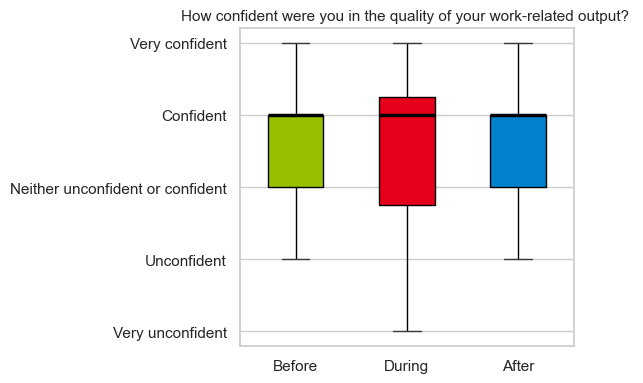

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\556338742.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- How did you perceive the communication with peers or colleagues? (Question adapted from Siegel et al ---
Independent t-test between before and during: t(59) = 3.42, p = 0.001
Independent t-test between during and after: t(60) = -3.45, p = 0.001
Independent t-test between before and after: t(59) = -0.06, p = 0.952


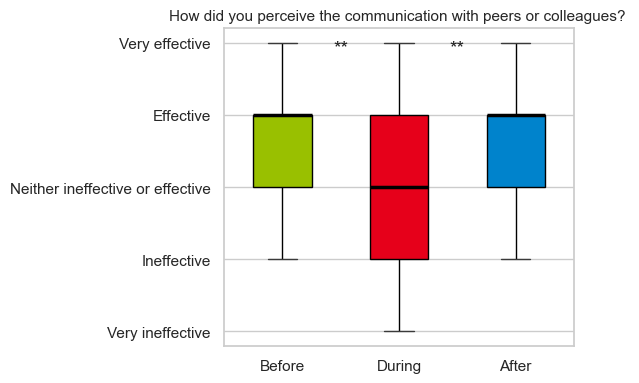


--- Did you feel disconnected from your academic or work environment? (Question adapted from Hohne et al ---
Independent t-test between before and during: t(59) = -4.45, p < .001
Independent t-test between during and after: t(60) = 4.03, p < .001
Independent t-test between before and after: t(59) = -0.72, p = 0.475


C:\Users\julia\AppData\Local\Temp\ipykernel_6540\556338742.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


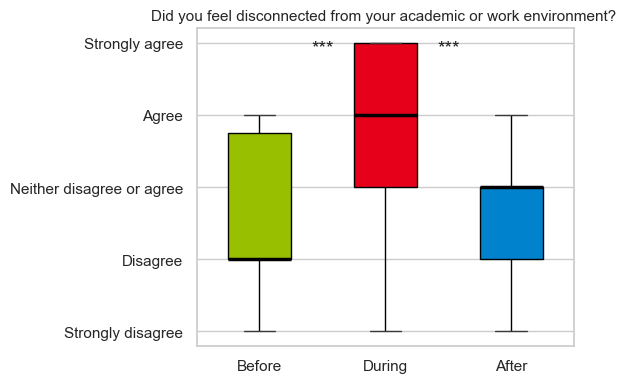

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\556338742.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- I feel that my practical computer science skills improved ---
Independent t-test between before and during: t(59) = 2.70, p = 0.009
Independent t-test between during and after: t(60) = -2.43, p = 0.018
Independent t-test between before and after: t(59) = 0.26, p = 0.792


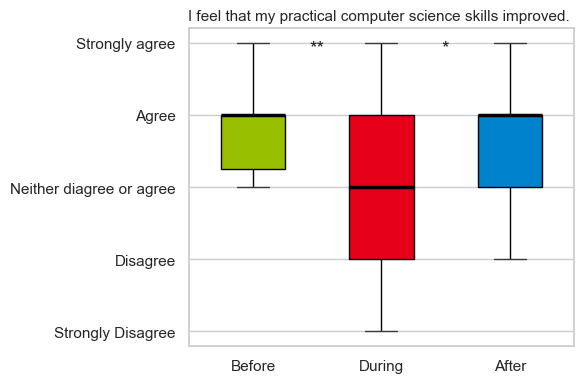

In [2]:
# === Colors and order
phase_colors = {
    "before": "#99C000",   # Green
    "during": "#E6001A",   # Red
    "after": "#0083CC"     # Blue
}
phase_order = ["before", "during", "after"]

# === Extract Likert mapping
def extract_numeric_mapping(responses):
    mapping = {}
    for resp in responses:
        match = re.match(r"(\d)\s*-\s*(.+)", str(resp))
        if match:
            num = int(match.group(1))
            label = match.group(2).strip()
            mapping[resp] = (num, label)
    return mapping if mapping else None

# === Build mappings per question
response_variants_by_question = df_likert.groupby("question")["response"].apply(list)
question_mappings = {}
for question, responses in response_variants_by_question.items():
    numeric_map = extract_numeric_mapping(responses)
    if numeric_map:
        question_mappings[question] = numeric_map

# === Add numeric score + label
df_mapped = df_likert.copy()
for question, mapping in question_mappings.items():
    mask = df_mapped["question"] == question
    df_mapped.loc[mask, "score"] = df_mapped.loc[mask, "response"].map(lambda x: mapping.get(x, (None, None))[0])
    df_mapped.loc[mask, "label"] = df_mapped.loc[mask, "response"].map(lambda x: mapping.get(x, (None, None))[1])
df_mapped = df_mapped.dropna(subset=["score"])
df_mapped["score"] = df_mapped["score"].astype(int)

# === Plot each question
sns.set(style="whitegrid")
for question in df_mapped["question"].unique():
    subset = df_mapped[df_mapped["question"] == question].copy()
    if subset["phase"].nunique() < 2:
        continue

    # Likert label mapping
    mapping = question_mappings.get(question, {})
    score_order = sorted({v[0] for v in mapping.values()})
    label_by_score = {v[0]: v[1] for v in mapping.values()}
    y_labels = [label_by_score[s] for s in score_order]

    # === Plot
    plt.figure(figsize=(6, 4))
    ax = sns.boxplot(
        data=subset,
        x="phase",
        y="score",
        order=phase_order,
        palette=phase_colors,
        width=0.5,
        showcaps=True,
        boxprops={"edgecolor": "black"},
        whiskerprops={"color": "black"},
        medianprops={"color": "black", "linewidth": 2.5},
        flierprops={'marker': ''},
        saturation=1.0,
    )
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Adjust Likert labels on y-axis (with override for specific question)
    if "mental well-being support from my university" in question:
        full_score_range = [1, 2, 3, 4, 5]
        likert_labels = {
            1: "Strongly Disagree",
            2: "Disagree",
            3: "Neutral",
            4: "Agree",
            5: "Strongly Agree"
        }
        plt.yticks(ticks=full_score_range, labels=[likert_labels[s] for s in full_score_range])
    elif "Did you feel pressure to appear constantly online or available at work?" in question:
        full_score_range = [1, 2, 3, 4, 5]
        likert_labels = {
            1: "Never",
            2: "Rarely",
            3: "Sometimes",
            4: "Often",
            5: "Always"
        }
        plt.yticks(ticks=full_score_range, labels=[likert_labels[s] for s in full_score_range])

    else:
        plt.yticks(ticks=score_order, labels=y_labels)
    plt.xticks(ticks=[0, 1, 2], labels=["Before", "During", "After"])
    plt.title(question.split('(')[0], fontsize=11)

    # === Statistical tests: independent t-test across all responses (not per user)
    p_vals = {}
    comparisons = [("before", "during"), ("during", "after"), ("before", "after")]
    for a, b in comparisons:
        scores_a = subset[subset["phase"] == a]["score"]
        scores_b = subset[subset["phase"] == b]["score"]
        if len(scores_a) > 1 and len(scores_b) > 1:
            stat, p = ttest_ind(scores_a, scores_b, equal_var=False)
            p_vals[(a, b)] = p
        else:
            p_vals[(a, b)] = np.nan

    # === Asterisks on plot
    y_max = max(score_order) - 0.2
    x_coords = {"before": 0, "during": 1, "after": 2}
    for (a, b), p in p_vals.items():
        if pd.notna(p):
            star = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
            if star:
                x1, x2 = x_coords[a], x_coords[b]
                x_mid = (x1 + x2) / 2
                ax.text(x_mid, y_max, star, ha='center', va='bottom', fontsize=14)

    # === Print p-values
    print(f"\n--- {question.split('.')[0].strip()} ---")
    for (a, b), p in p_vals.items():
        scores_a = subset[subset["phase"] == a]["score"]
        scores_b = subset[subset["phase"] == b]["score"]

        if len(scores_a) > 1 and len(scores_b) > 1:
            t_stat, p_val = ttest_ind(scores_a, scores_b, equal_var=False)
            df_likert = len(scores_a) + len(scores_b) - 2
            p_report = "< .001" if p_val < 0.001 else f"= {p_val:.3f}"
            print(f"Independent t-test between {a} and {b}: t({df_likert}) = {t_stat:.2f}, p {p_report}")

    plt.tight_layout()
    plt.show()


## One time answered questions

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\3917723175.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


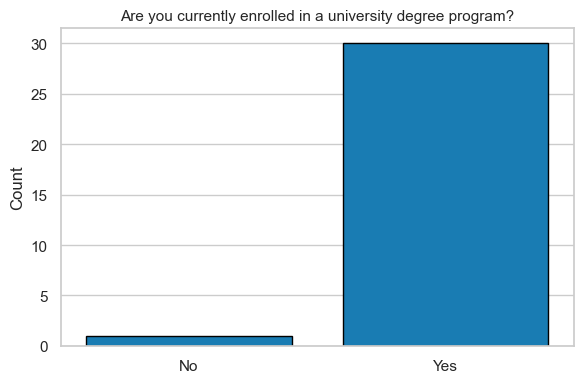

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\3917723175.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


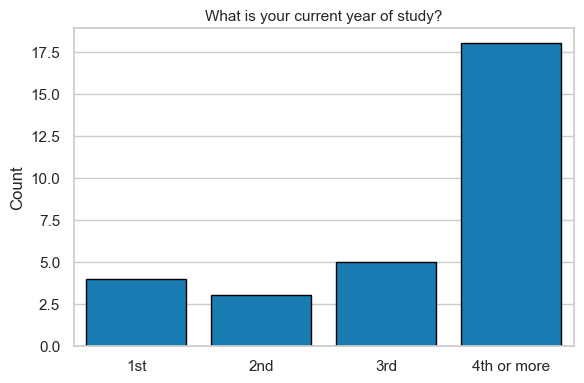

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\3917723175.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


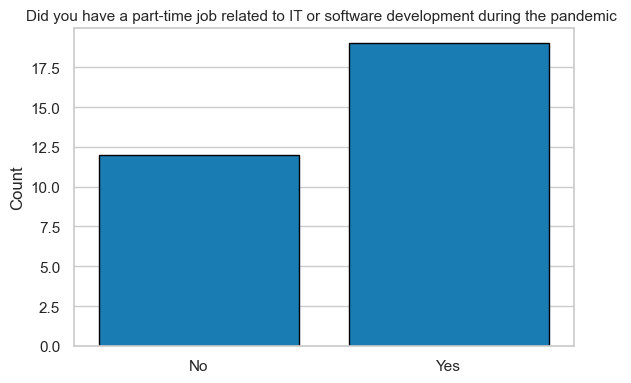

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\3917723175.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


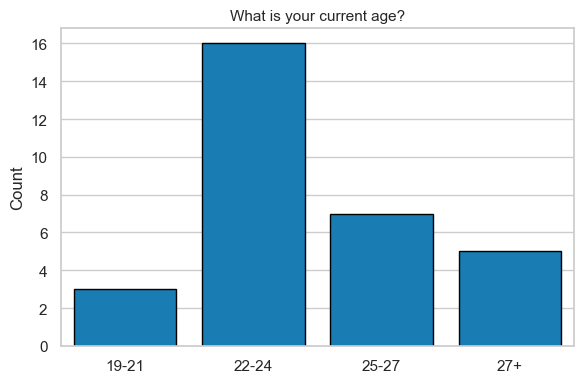

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\3917723175.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


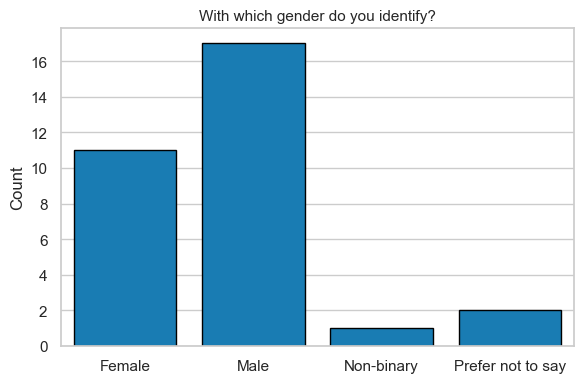

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\3917723175.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


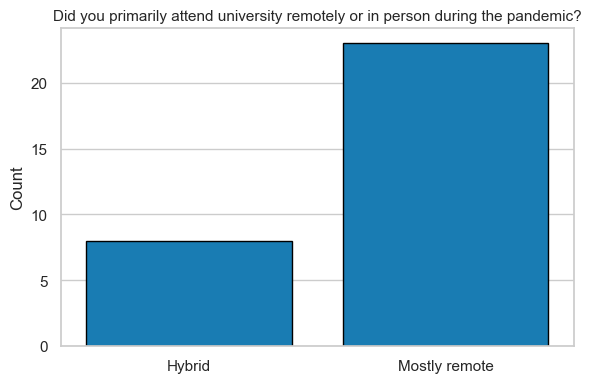

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\3917723175.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


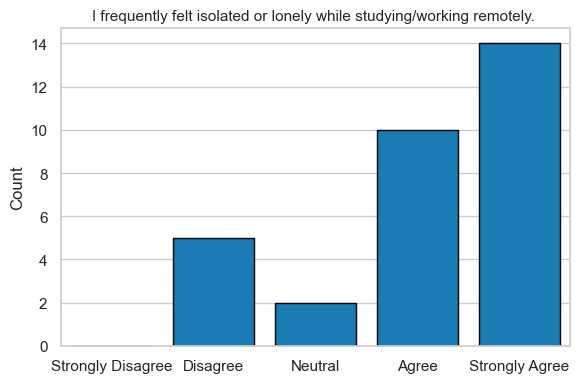

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\3917723175.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


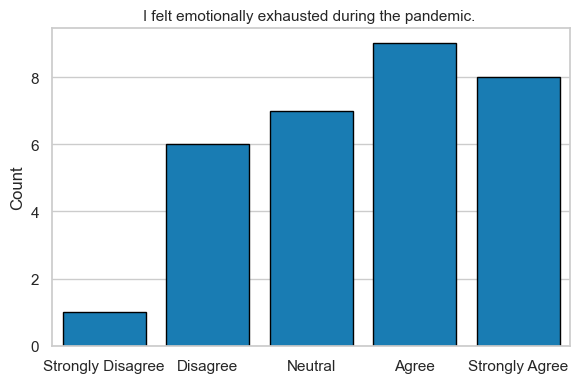

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\3917723175.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


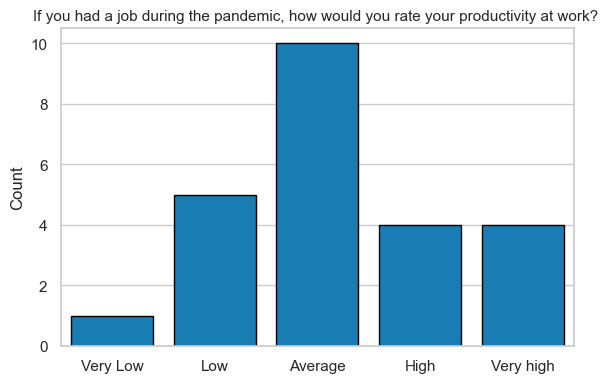

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\3917723175.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


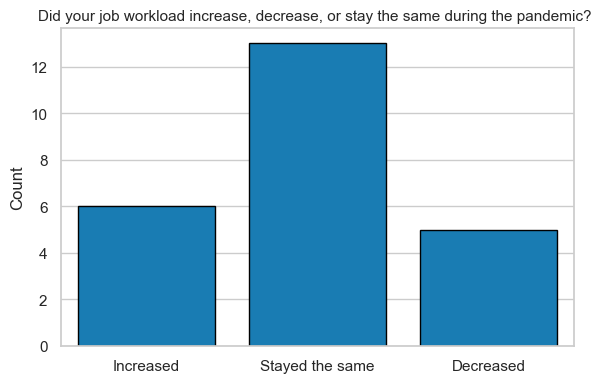

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\3917723175.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


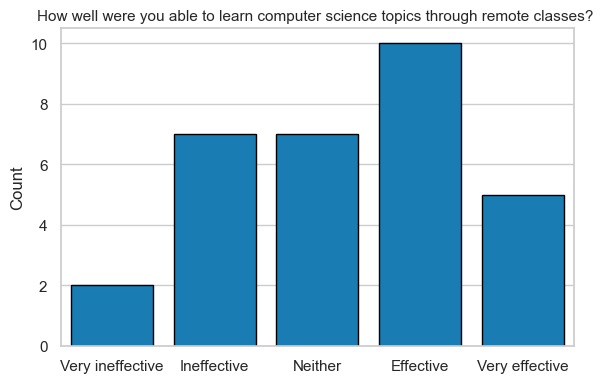

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\3917723175.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


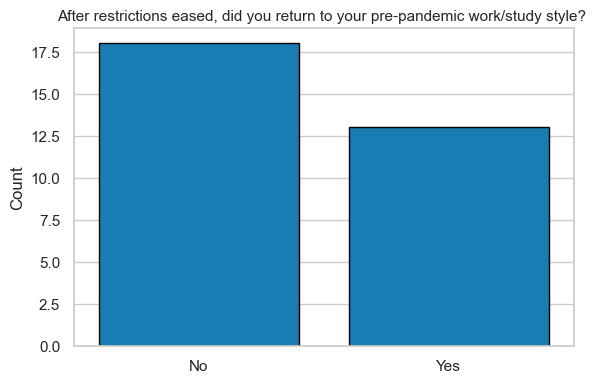

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\3917723175.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


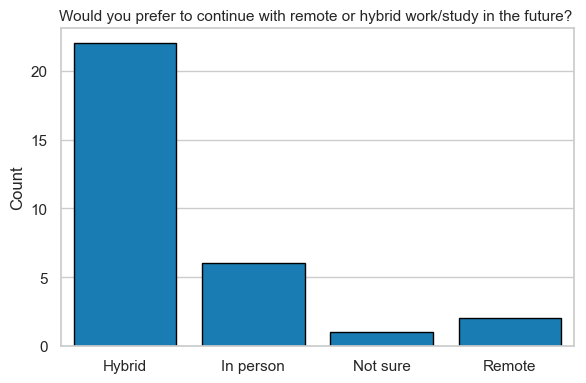

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\3917723175.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


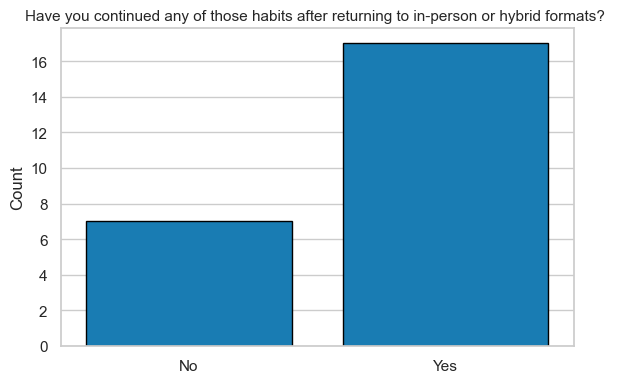

C:\Users\julia\AppData\Local\Temp\ipykernel_6540\3917723175.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


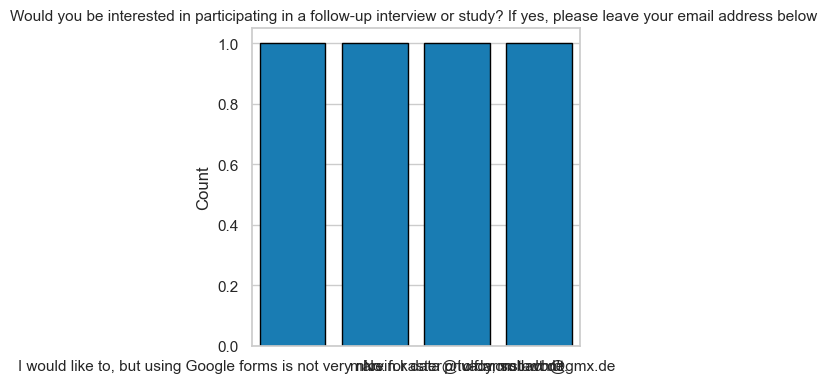

In [3]:
df_likert = pd.read_csv("../data/likert_responses.csv")

# Filter for questions only asked once (e.g., yes/no or similar)
df_single_phase = df_likert[df_likert["phase"] == "yes/no"].copy()

# Plot settings
sns.set(style="whitegrid")

# Custom blue color
custom_color = "#0083CC"

# Loop through each single-phase question
for question in df_single_phase["question"].unique():
    subset = df_single_phase[df_single_phase["question"] == question]

    # Define expected responses and short label mapping (if applicable)
    expected_responses = None
    short_labels = None

    if "felt isolated or lonely while studying/working remotely" in question:
        expected_responses = [
            "1 - Strongly disagree",
            "2 - Disagree",
            "3 - Neither disagree or agree",
            "4 - Agree",
            "5 - Strongly agree"
        ]
        short_labels = {
            "1 - Strongly disagree": "Strongly Disagree",
            "2 - Disagree": "Disagree",
            "3 - Neither disagree or agree": "Neutral",
            "4 - Agree": "Agree",
            "5 - Strongly agree": "Strongly Agree"
        }

    elif "felt emotionally exhausted during the pandemic" in question:
        short_labels = {
            "1 - Strongly Disagree": "Strongly Disagree",
            "2 - Disagree": "Disagree",
            "3 - Neither disagree or agree": "Neutral",
            "4 - Agree": "Agree",
            "5 - Strongly agree": "Strongly Agree"
        }

    elif "had a job during the pandemic" in question:
        short_labels = {
            "1 - Very Low": "Very Low",
            "2 - Low": "Low",
            "3 - Average": "Average",
            "4 - High": "High",
            "5 - Very high": "Very high"
        }

    elif "your job workload increase" in question:
        short_labels = {
            "1 - Increased": "Increased",
            "2 - Stayed the same": "Stayed the same",
            "3 - Decreased": "Decreased"
        }

    elif "well were you able to learn computer" in question:
        short_labels = {
            "1 - Very ineffective": "Very ineffective",
            "2 - Ineffective": "Ineffective",
            "3 - Neither effective or ineffective": "Neither",
            "4 - Effective": "Effective",
            "5 - Very effective": "Very effective"
        }
        
    # === Get response counts
    if expected_responses:
        response_counts = subset["response"].value_counts()
        response_counts = response_counts.reindex(expected_responses, fill_value=0)
    else:
        response_counts = subset["response"].value_counts().sort_index()

    # === Set display labels
    if short_labels:
        display_labels = [short_labels.get(resp, resp) for resp in response_counts.index]
    else:
        display_labels = response_counts.index

    # Plot bar chart
    plt.figure(figsize=(6, 4))
    sns.barplot(
        x=response_counts.index,
        y=response_counts.values,
        palette=[custom_color] * len(response_counts),
        edgecolor="black"
    )
    
    plt.title(question.split('(')[0], fontsize=11)
    plt.xlabel("")
    plt.ylabel("Count")
    plt.xticks(ticks=range(len(display_labels)), labels=display_labels, rotation=0, ha="center")
    plt.tight_layout()
    plt.show()


## Plot for RQ 1 Poster

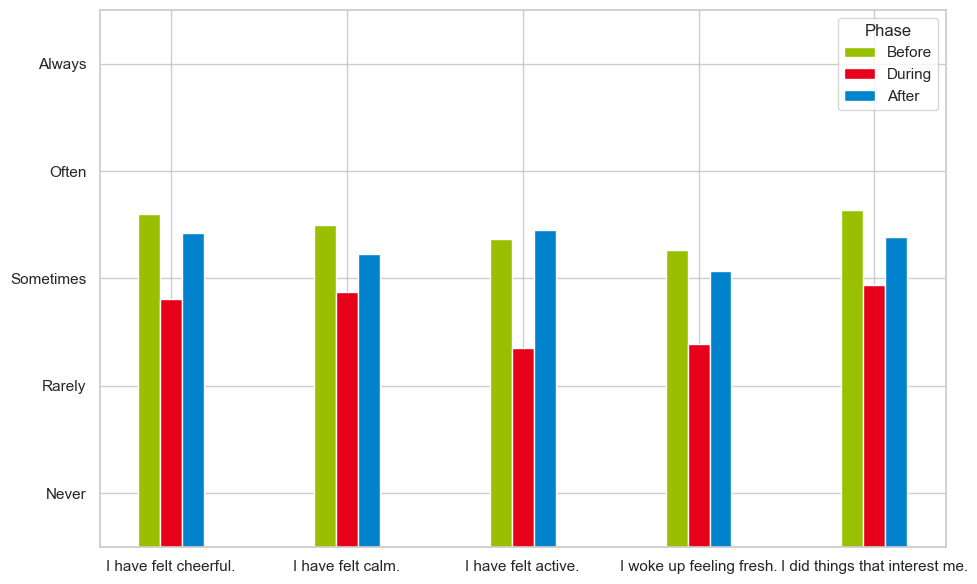

In [4]:
# === Label mappings
score_labels = {
    1: "Never", 2: "Rarely", 3: "Sometimes", 4: "Often", 5: "Always"
}

clean_labels = {
    "I have felt cheerful and in good spirits. (Question identical to WHO-5 Well-Being Index)": "I have felt cheerful.",
    "In this phase, how often did you feel calm and relaxed? (Question identical to WHO-5 Well-Being Index)": "I have felt calm.",
    "I have felt active and vigorous. (Question identical to WHO-5 Well-Being Index)": "I have felt active.",
    "I woke up feeling fresh and rested. (Question identical to WHO-5 Well-Being Index)": "I woke up feeling fresh.",
    "My daily life has been filled with things that interest me. (Question identical to WHO-5 Well-Being Index)": "I did things that interest me."
}

phase_order = ["before", "during", "after"]

# === Filter WHO-5 data
subset = df_mapped[df_mapped["question"].isin(clean_labels.keys())].copy()
subset["short_question"] = subset["question"].map(clean_labels)

# === Compute average scores
avg_df = (
    subset.groupby(["short_question", "phase"])["score"]
    .mean()
    .reset_index(name="avg_score")
)

# === Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
group_gap = 1

x_positions = []
x_labels = []
questions = list(clean_labels.values())

for i, question in enumerate(questions):
    for j, phase in enumerate(phase_order):
        row = avg_df[
            (avg_df["short_question"] == question) &
            (avg_df["phase"] == phase)
        ]
        if not row.empty:
            avg_score = row["avg_score"].values[0]
        else:
            avg_score = 0  # fallback

        xpos = i * (len(phase_order) * bar_width + group_gap) + j * bar_width
        x_positions.append(xpos)
        x_labels.append("")  # suppress individual phase names on x-axis
        ax.bar(
            xpos,
            avg_score,
            width=bar_width,
            color=phase_colors[phase],
            label=phase.capitalize() if i == 0 else None
        )

# === Styling
group_centers = [
    i * (len(phase_order) * bar_width + group_gap) + bar_width
    for i in range(len(questions))
]
ax.set_xticks(group_centers)
ax.set_xticklabels(questions, rotation=0, ha='center')

# ax.set_ylabel("Average Likert Score")
ax.set_ylim(0.5, 5.5)
ax.set_yticks(list(score_labels.keys()))
ax.set_yticklabels(score_labels.values())

# ax.set_title("WHO-5 Well-Being Items: Average Response by Phase")
ax.legend(title="Phase")
plt.tight_layout()
plt.show()

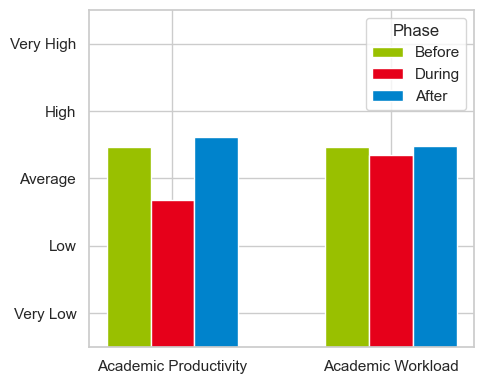

In [5]:
# === Define mappings
phase_colors = {
    "before": "#99C000",   # Green
    "during": "#E6001A",   # Red
    "after": "#0083CC"     # Blue
}
phase_order = ["before", "during", "after"]

score_labels = {
    1: "Very Low", 2: "Low", 3: "Average", 4: "High", 5: "Very High"
}

# Cleaned short versions of the target questions
clean_labels = {
    "How would you rate your academic productivity during this time? (Question adapted from Ralph et al. (2020); Russo et al. (2021))": "Academic Productivity",
    "How much was your academic workload on average? (Question adapted from Baticulon et al. (2021))": "Academic Workload"
}

# === Filter and prepare the subset
subset = df_mapped[df_mapped["question"].isin(clean_labels.keys())].copy()
subset["short_question"] = subset["question"].map(clean_labels)

# === Compute average scores
avg_df = (
    subset.groupby(["short_question", "phase"])["score"]
    .mean()
    .reset_index(name="avg_score")
)

# === Plotting
fig, ax = plt.subplots(figsize=(5, 4))
bar_width = 0.1
group_gap = 0.2

x_positions = []
x_labels = []
questions = list(clean_labels.values())

for i, question in enumerate(questions):
    for j, phase in enumerate(phase_order):
        row = avg_df[
            (avg_df["short_question"] == question) &
            (avg_df["phase"] == phase)
        ]
        avg_score = row["avg_score"].values[0] if not row.empty else 0

        xpos = i * (len(phase_order) * bar_width + group_gap) + j * bar_width
        x_positions.append(xpos)
        x_labels.append("")  # hide phase labels below each bar
        ax.bar(
            xpos,
            avg_score,
            width=bar_width,
            color=phase_colors[phase],
            label=phase.capitalize() if i == 0 else None
        )

# === Styling
group_centers = [
    i * (len(phase_order) * bar_width + group_gap) + bar_width
    for i in range(len(questions))
]
ax.set_xticks(group_centers)
ax.set_xticklabels(questions, rotation=0, ha='center')

ax.set_ylim(0.5, 5.5)
ax.set_yticks(list(score_labels.keys()))
ax.set_yticklabels(score_labels.values())

ax.legend(title="Phase")
plt.tight_layout()
plt.show()


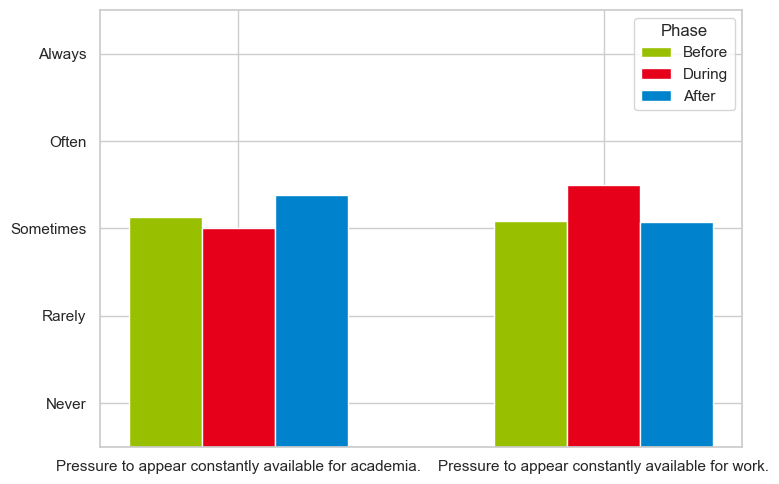

In [6]:
# === Define mappings
phase_colors = {
    "before": "#99C000",   # Green
    "during": "#E6001A",   # Red
    "after": "#0083CC"     # Blue
}
phase_order = ["before", "during", "after"]

score_labels = {
    1: "Never", 2: "Rarely", 3: "Sometimes", 4: "Often", 5: "Always"
}

# Cleaned short versions of the target questions
clean_labels = {
    "Did you feel pressure to appear constantly available or responsive for academic obligations? (Question adapted from Ralph et al. (2020))": "Pressure to appear constantly available for academia.",
    "Did you feel pressure to appear constantly online or available at work? (Question adapted from Ralph et al. (2020))": "Pressure to appear constantly available for work."
}

# === Filter and prepare the subset
subset = df_mapped[df_mapped["question"].isin(clean_labels.keys())].copy()
subset["short_question"] = subset["question"].map(clean_labels)

# === Compute average scores
avg_df = (
    subset.groupby(["short_question", "phase"])["score"]
    .mean()
    .reset_index(name="avg_score")
)

# === Plotting
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.1
group_gap = 0.2

x_positions = []
x_labels = []
questions = list(clean_labels.values())

for i, question in enumerate(questions):
    for j, phase in enumerate(phase_order):
        row = avg_df[
            (avg_df["short_question"] == question) &
            (avg_df["phase"] == phase)
        ]
        avg_score = row["avg_score"].values[0] if not row.empty else 0

        xpos = i * (len(phase_order) * bar_width + group_gap) + j * bar_width
        x_positions.append(xpos)
        x_labels.append("")  # hide phase labels below each bar
        ax.bar(
            xpos,
            avg_score,
            width=bar_width,
            color=phase_colors[phase],
            label=phase.capitalize() if i == 0 else None
        )

# === Styling
group_centers = [
    i * (len(phase_order) * bar_width + group_gap) + bar_width
    for i in range(len(questions))
]
ax.set_xticks(group_centers)
ax.set_xticklabels(questions, rotation=0, ha='center')

ax.set_ylim(0.5, 5.5)
ax.set_yticks(list(score_labels.keys()))
ax.set_yticklabels(score_labels.values())

ax.legend(title="Phase")
plt.tight_layout()
plt.show()


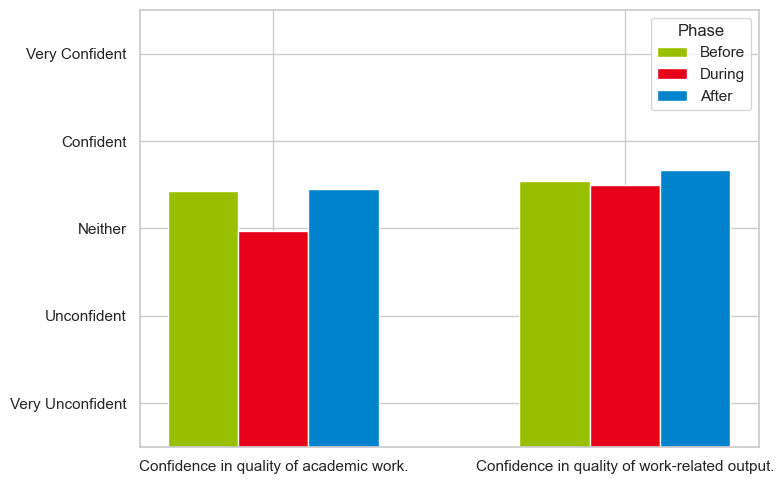

In [7]:
# === Define mappings
phase_colors = {
    "before": "#99C000",   # Green
    "during": "#E6001A",   # Red
    "after": "#0083CC"     # Blue
}
phase_order = ["before", "during", "after"]

score_labels = {
    1: "Very Unconfident", 2: "Unconfident", 3: "Neither", 4: "Confident", 5: "Very Confident"
}

# Cleaned short versions of the target questions
clean_labels = {
    "How confident did you feel in the quality of your academic work? (Question adapted from Ralph et al. (2020); Russo et al. (2021))": "Confidence in quality of academic work.",
    "How confident were you in the quality of your work-related output? (Question adapted from Ralph et al. (2020); Russo et al. (2021))": "Confidence in quality of work-related output."
}

# === Filter and prepare the subset
subset = df_mapped[df_mapped["question"].isin(clean_labels.keys())].copy()
subset["short_question"] = subset["question"].map(clean_labels)

# === Compute average scores
avg_df = (
    subset.groupby(["short_question", "phase"])["score"]
    .mean()
    .reset_index(name="avg_score")
)

# === Plotting
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.1
group_gap = 0.2

x_positions = []
x_labels = []
questions = list(clean_labels.values())

for i, question in enumerate(questions):
    for j, phase in enumerate(phase_order):
        row = avg_df[
            (avg_df["short_question"] == question) &
            (avg_df["phase"] == phase)
        ]
        avg_score = row["avg_score"].values[0] if not row.empty else 0

        xpos = i * (len(phase_order) * bar_width + group_gap) + j * bar_width
        x_positions.append(xpos)
        x_labels.append("")  # hide phase labels below each bar
        ax.bar(
            xpos,
            avg_score,
            width=bar_width,
            color=phase_colors[phase],
            label=phase.capitalize() if i == 0 else None
        )

# === Styling
group_centers = [
    i * (len(phase_order) * bar_width + group_gap) + bar_width
    for i in range(len(questions))
]
ax.set_xticks(group_centers)
ax.set_xticklabels(questions, rotation=0, ha='center')

ax.set_ylim(0.5, 5.5)
ax.set_yticks(list(score_labels.keys()))
ax.set_yticklabels(score_labels.values())

ax.legend(title="Phase")
plt.tight_layout()
plt.show()

##  Correlations between mental well-being scores and perceived productivity

In [8]:
# === Define helper to extract score from Likert responses
def extract_score(response):
    match = re.match(r"(\d)\s*-\s*", str(response))
    return int(match.group(1)) if match else np.nan

# Apply score extraction
df_likert["score"] = df_likert["response"].apply(extract_score)

# === Define relevant questions
wellbeing_keywords = [
    "I have felt cheerful and in good spirits",
    "how often did you feel calm and relaxed",
    "I have felt active and vigorous",
    "I woke up feeling fresh and rested",
    "My daily life has been filled with things that interest me",
]
productivity_keywords = [
    "academic productivity",
    "academic workload",
    "pressure to appear constantly online",
    "emotionally exhausted"
]

# === Filter questions by keyword
def match_keywords(row, keywords):
    return any(k.lower() in row.lower() for k in keywords)

df_wb = df_likert[df_likert["question"].apply(lambda q: match_keywords(q, wellbeing_keywords))]
df_prod = df_likert[df_likert["question"].apply(lambda q: match_keywords(q, productivity_keywords))]

# === Pivot to wide format
wb_pivot = df_wb.pivot_table(index="participant", columns="question", values="score")
prod_pivot = df_prod.pivot_table(index="participant", columns="question", values="score")

# === Merge on participant level
merged = pd.merge(wb_pivot, prod_pivot, on="participant", suffixes=("_wb", "_prod"))

# === Compute correlations
correlation_matrix = merged.corr().loc[wb_pivot.columns, prod_pivot.columns]

# Show result
print("Correlation matrix between mental well-being and productivity/engagement:")
print(correlation_matrix.round(2))


Correlation matrix between mental well-being and productivity/engagement:
question                                            Did you feel pressure to appear constantly online or available at work? (Question adapted from Ralph et al. (2020))  \
question                                                                                                                                                                  
I have felt active and vigorous. (Question iden...                                               0.02                                                                     
I have felt cheerful and in good spirits. (Ques...                                               0.18                                                                     
I woke up feeling fresh and rested. (Question i...                                               0.14                                                                     
In this phase, how often did you feel calm and ...                     